# Pandas Loan Book Analysis

MASTIX Studio can be run as a batch calculation to deliver results in e.g. CSV-files for further analysis.
This notebook contains an example of output from a loan book calculation and how it can be imported into Pandas.

## Loan Book Specification
The loan book contains 400k loans, 200k in SEK and 200K in NOK. Half of the loans in each currency are fixed loans and half are floating rate loans.


## Calculations
MASTIX Studio calculates all the cash flows for the loans in forward terms, together with their sensitivities to interest rates. The FX-rates and the discount factors are also provided separately. To combine the 
dataframes with correct handling of all sensitivities, the **MASTIX Python Utils** are used.


#### Import libraries

In [1]:
mastix_path = "C:\\Mastix Studio\\"
data_path = "C:\\Data\\"

In [2]:
import sys

sys.path.append(mastix_path)

import numpy as np
import pandas as pd
from mastixpy import Value

#### Load data
The CSV-files containing cash flows, discount factors and fx rates are loaded into Pandas dataframes.

In [3]:
%%time

sekCashFlows = pd.read_csv(data_path + 'SEK_CashFlows_20220816.csv', delimiter=';', decimal=',', parse_dates=[3])
nokCashFlows = pd.read_csv(data_path + 'NOK_CashFlows_20220816.csv', delimiter=';', decimal=',', parse_dates=[3])

sekDiscountFactors = pd.read_csv(data_path + 'SEK_Discount_Factors_20220816.csv', delimiter=';', decimal=',', index_col=0, parse_dates=[0])
nokDiscountFactors = pd.read_csv(data_path + 'NOK_Discount_Factors_20220816.csv', delimiter=';', decimal=',', index_col=0, parse_dates=[0])

fxRates = pd.read_csv(data_path + 'Fx_Rates_20220816.csv', delimiter=';', decimal=',', index_col=0, usecols=lambda x: x != 'Price Currency')

CPU times: total: 2.62 s
Wall time: 3.12 s


#### Format the dataframes
The column name for the cash flow amount is changed to a more descriptive one.

In [4]:
sekCashFlows.rename(columns={'Amount': 'Forward Value (Currency)'}, inplace=True)
nokCashFlows.rename(columns={'Amount': 'Forward Value (Currency)'}, inplace=True)

The derivatives can be obtained in any preferred order by defining the order in an array.

In [5]:
preferred_derivatives_order = ['SEK Appreciation', 'NOK Appreciation', 'USD Appreciation',
                               'USDNOK Fx Spot Rate', 'USDSEK Fx Spot Rate',
                               'SEK.DSC.1D', 'SEK.DSC.1W', 'SEK.DSC.2W', 'SEK.DSC.1M', 'SEK.DSC.2M',
                               'SEK.DSC.3M', 'SEK.DSC.6M', 'SEK.DSC.1Y', 'SEK.DSC.2Y', 'SEK.DSC.3Y',
                               'SEK.DSC.5Y', 'SEK.DSC.10Y', 'SEK.DSC.15Y', 'SEK.DSC.20Y', 'SEK.DSC.30Y',
                               'NOK.DSC.1D', 'NOK.DSC.1W', 'NOK.DSC.2W', 'NOK.DSC.1M', 'NOK.DSC.2M',
                               'NOK.DSC.3M', 'NOK.DSC.6M', 'NOK.DSC.1Y', 'NOK.DSC.2Y', 'NOK.DSC.3Y',
                               'NOK.DSC.5Y', 'NOK.DSC.10Y', 'NOK.DSC.15Y', 'NOK.DSC.20Y', 'NOK.DSC.30Y'
                               'USD.DSC.1D', 'USD.DSC.1M', 'USD.DSC.1W', 'USD.DSC.2W',
                               'SEK.3M.1D', 'SEK.3M.1W', 'SEK.3M.2W', 'SEK.3M.1M', 'SEK.3M.2M',
                               'SEK.3M.3M', 'SEK.3M.6M', 'SEK.3M.1Y', 'SEK.3M.2Y', 'SEK.3M.3Y',
                               'SEK.3M.5Y', 'SEK.3M.10Y', 'SEK.3M.15Y', 'SEK.3M.20Y', 'SEK.3M.30Y',
                               'NOK.3M.1D', 'NOK.3M.1W', 'NOK.3M.2W', 'NOK.3M.1M', 'NOK.3M.2M',
                               'NOK.3M.3M', 'NOK.3M.6M', 'NOK.3M.1Y', 'NOK.3M.2Y', 'NOK.3M.3Y',
                               'NOK.3M.5Y', 'NOK.3M.10Y', 'NOK.3M.15Y', 'NOK.3M.20Y', 'NOK.3M.30Y']

#### Perform calculations on Dataframes
The cash flows are bound to the corresponding discount factors and FX-rates.

In [6]:
%%time

sek_cf_df = Value(sekCashFlows[['Pay']].merge(sekDiscountFactors, left_on='Pay', right_index=True), 'Discount Factor', sekDiscountFactors.columns[1:])
nok_cf_df = Value(nokCashFlows[['Pay']].merge(nokDiscountFactors, left_on='Pay', right_index=True), 'Discount Factor', nokDiscountFactors.columns[1:])

sek_cf_fx = Value(sekCashFlows[['Currency']].merge(fxRates, left_on='Currency', right_index=True), 'Fx Rate', fxRates.columns[1:])
nok_cf_fx = Value(nokCashFlows[['Currency']].merge(fxRates, left_on='Currency', right_index=True), 'Fx Rate', fxRates.columns[1:])

sek_cf_df_SEK = Value(sekCashFlows[['Pay']].merge(sekDiscountFactors, left_on='Pay', right_index=True), 'Discount Factor', sekDiscountFactors.columns[1:])
nok_cf_df_SEK = Value(nokCashFlows[['Pay']].merge(sekDiscountFactors, left_on='Pay', right_index=True), 'Discount Factor', sekDiscountFactors.columns[1:])

CPU times: total: 1.22 s
Wall time: 1.51 s


Using the **MASTIX Python Utils**, the present value in currency ($PV^{\textrm{ccy}}$) as well as present value and forward value in SEK ($PV^{\textrm{SEK}}$ and $FV^{\textrm{SEK}}$) are calculated. 

\begin{align*}
FV^{\textrm{ccy}} &= a^{\textrm{ccy}}  \\
PV^{\textrm{ccy}} &= FV^{\textrm{ccy}} DF^{\textrm{ccy}} \\
PV^{\textrm{SEK}} &= PV^{\textrm{ccy}} FX^{\textrm{ccy},\textrm{SEK}}\\
FV^{\textrm{SEK}} &= \frac{PV^{\textrm{SEK}}}{DF^{\textrm{SEK}}}, \\
\end{align*}

where $DF^{\textrm{SEK}}$ is the discount factor in $\textrm{SEK}$ and $FX^{\textrm{ccy},\textrm{SEK}}$ is the exchange rate from $\textrm{ccy}$ to $\textrm{SEK}$.

The MASTIX Python library propagates the sensitivities when performing operations on the dataframes. The sensitivities propagate according to:

\begin{align*}
\frac{dFV^{\textrm{ccy}}}{dx} & = \frac{da^{\textrm{ccy}}}{dx} \\
\frac{dPV^{\textrm{ccy}}}{dx} & = \frac{dFV^{\textrm{ccy}}}{dx} DF^{\textrm{ccy}} + FV^{\textrm{ccy}} \frac{dDF^{\textrm{ccy}}}{dx} \\
\frac{dPV^{\textrm{SEK}}}{dx} & = \frac{dPV^{\textrm{ccy}}}{dx} FX^{\textrm{ccy},\textrm{SEK}}  + PV^{\textrm{ccy}} \frac{dFX^{\textrm{ccy},\textrm{SEK}}}{dx} \\
\frac{dFV^{\textrm{SEK}}}{dx} & = \frac{dPV^{\textrm{SEK}} }{dx} \frac{1}{DF^{\textrm{SEK}}} - PV^{\textrm{SEK}}  \frac{1}{(DF^{\textrm{SEK}})^2} \frac{dDF^{\textrm{SEK}}}{dx} 
\end{align*}

The dataframes are wrapped into MASTIX Python objects and the values are calculated.

In [7]:
%%time

sek_cf_fv = Value(sekCashFlows, 'Forward Value (Currency)', sekCashFlows.columns[6:], ['Trade Id', 'Cash Flow', 'Pay'], preferred_derivatives_order)
nok_cf_fv = Value(nokCashFlows, 'Forward Value (Currency)', nokCashFlows.columns[6:], ['Trade Id', 'Cash Flow', 'Pay'], preferred_derivatives_order)

sek_cf_pv = sek_cf_fv.multiply(sek_cf_df, 'Present Value (Currency)', preferred_derivatives_order)
nok_cf_pv = nok_cf_fv.multiply(nok_cf_df, 'Present Value (Currency)', preferred_derivatives_order)

sek_cf_pv_SEK = sek_cf_pv.multiply(sek_cf_fx, 'Present Value (SEK)', preferred_derivatives_order)
nok_cf_pv_SEK = nok_cf_pv.multiply(nok_cf_fx, 'Present Value (SEK)', preferred_derivatives_order)

sek_cf_fv_SEK = sek_cf_pv_SEK.divide(sek_cf_df_SEK, 'Forward Value (SEK)', preferred_derivatives_order)
nok_cf_fv_SEK = nok_cf_pv_SEK.divide(nok_cf_df_SEK, 'Forward Value (SEK)', preferred_derivatives_order)

CPU times: total: 2.53 s
Wall time: 4.28 s


Set index based on Trade Id and Cash flow number within trade.

In [8]:
%%time

sek_cf_fv = sek_cf_fv.data_frame.set_index(['Trade Id', 'Cash Flow'])
nok_cf_fv = nok_cf_fv.data_frame.set_index(['Trade Id', 'Cash Flow'])

sek_cf_pv = sek_cf_pv.data_frame.set_index(['Trade Id', 'Cash Flow'])
nok_cf_pv = nok_cf_pv.data_frame.set_index(['Trade Id', 'Cash Flow'])

sek_cf_pv_SEK = sek_cf_pv_SEK.data_frame.set_index(['Trade Id', 'Cash Flow'])
nok_cf_pv_SEK = nok_cf_pv_SEK.data_frame.set_index(['Trade Id', 'Cash Flow'])

sek_cf_fv_SEK = sek_cf_fv_SEK.data_frame.set_index(['Trade Id', 'Cash Flow'])
nok_cf_fv_SEK = nok_cf_fv_SEK.data_frame.set_index(['Trade Id', 'Cash Flow'])

CPU times: total: 1.27 s
Wall time: 2.6 s


#### Memory usage
The memory usages of the dataframes are as follows:

In [9]:
print(f'sek_cf_fv:      {int(sek_cf_fv.memory_usage().sum()/1e6):,} MB')
print(f'nok_cf_fv:      {int(nok_cf_fv.memory_usage().sum()/1e6):,} MB')
print()
print(f'sek_cf_pv:      {int(sek_cf_pv.memory_usage().sum()/1e6):,} MB')
print(f'nok_cf_pv:      {int(nok_cf_pv.memory_usage().sum()/1e6):,} MB')
print()
print(f'sek_cf_pv_SEK:  {int(sek_cf_pv_SEK.memory_usage().sum()/1e6):,} MB')
print(f'nok_cf_pv_SEK:  {int(nok_cf_pv_SEK.memory_usage().sum()/1e6):,} MB')
print()
print(f'sek_cf_fv_SEK:  {int(sek_cf_fv_SEK.memory_usage().sum()/1e6):,} MB')
print(f'nok_cf_fv_SEK:  {int(nok_cf_fv_SEK.memory_usage().sum()/1e6):,} MB')

sek_cf_fv:      298 MB
nok_cf_fv:      298 MB

sek_cf_pv:      548 MB
nok_cf_pv:      530 MB

sek_cf_pv_SEK:  748 MB
nok_cf_pv_SEK:  729 MB

sek_cf_fv_SEK:  748 MB
nok_cf_fv_SEK:  911 MB


## Analysis with Pandas
With these dataframes prepared, a thorough analysis can be performed. The forward and present values of each cash flow in every loan is calculated -- together with sensitivities against all relevant risk factors.

In [10]:
nok_cf_fv_SEK.head()

Pay  Forward Value (SEK)  SEK Appreciation  \
Trade Id Cash Flow                                                     
A1       1         2022-08-25          1200.756457      -1200.756457   
         2         2022-09-26          1239.490536      -1239.490536   
         3         2022-10-25          1123.288299      -1123.288299   
         4         2022-11-25          1200.756457      -1200.756457   
         5         2022-12-27          1239.490536      -1239.490536   

                    NOK Appreciation  USD Appreciation  USDNOK Fx Spot Rate  \
Trade Id Cash Flow                                                            
A1       1               1200.756457     -2.459910e-13          -147.718142   
         2               1239.490536     -2.539262e-13          -152.483243   
         3               1123.288299     -2.301206e-13          -138.187939   
         4               1200.756457     -2.459910e-13          -147.718142   
         5               1239.490536     -2.539262e-13          -152.483243   

                    USDSEK Fx Spot Rate  SEK.DSC.1D  SEK.DSC.1W  SEK.DSC.2W  \
Trade Id Cash Flow                                                            
A1       1                   136.297811   -5.512703   20.158712    8.504502   
         2                   140.694515   -5.690532   20.808993    8.778841   
         3                   127.504404   -5.157044   18.858150    7.955824   
         4                   136.297811   -5.512703   20.158712    8.504502   
         5                   140.694515   -5.690532   20.808993    8.778841   

                    ...  NOK.3M.3M  NOK.3M.6M  NOK.3M.1Y  NOK.3M.2Y  \
Trade Id Cash Flow  ...                                               
A1       1          ...        0.0        0.0        0.0        0.0   
         2          ...        0.0        0.0        0.0        0.0   
         3          ...        0.0        0.0        0.0        0.0   
         4          ...        0.0        0.0        0.0        0.0   
         5          ...        0.0        0.0        0.0        0.0   

                    NOK.3M.3Y  NOK.3M.5Y  NOK.3M.10Y  NOK.3M.15Y  NOK.3M.20Y  \
Trade Id Cash Flow                                                             
A1       1                0.0        0.0         0.0         0.0         0.0   
         2                0.0        0.0         0.0         0.0         0.0   
         3                0.0        0.0         0.0         0.0         0.0   
         4                0.0        0.0         0.0         0.0         0.0   
         5                0.0        0.0         0.0         0.0         0.0   

                    NOK.3M.30Y  
Trade Id Cash Flow              
A1       1                 0.0  
         2                 0.0  
         3                 0.0  
         4                 0.0  
         5                 0.0  

[5 rows x 54 columns]

The cash flows can be grouped per month:

In [11]:
grouped_risks = nok_cf_fv_SEK.groupby(pd.Grouper(key='Pay', freq='M')).sum()
grouped_risks.head()

,Forward Value (SEK),SEK Appreciation,NOK Appreciation,USD Appreciation,USDNOK Fx Spot Rate,USDSEK Fx Spot Rate,SEK.DSC.1D,SEK.DSC.1W,SEK.DSC.2W,SEK.DSC.1M,...,NOK.3M.3M,NOK.3M.6M,NOK.3M.1Y,NOK.3M.2Y,NOK.3M.3Y,NOK.3M.5Y,NOK.3M.10Y,NOK.3M.15Y,NOK.3M.20Y,NOK.3M.30Y
Pay,,,,,,,,,,,,,,,,,,,,,
2022-08-31,-1.860425e+08,1.860425e+08,-1.860425e+08,3.811330e-08,2.288712e+07,-2.111768e+07,8.463491e+05,127309.718578,-8.386006e+04,-1.146407e+06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-30,7.060583e+08,-7.060583e+08,7.060583e+08,-1.446455e-07,-8.685992e+07,8.014464e+07,-3.197097e+06,-333013.668012,1.286129e+06,5.627906e+06,...,3.239436e+08,3.774065e+07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-31,1.528193e+09,-1.528193e+09,1.528193e+09,-3.130707e-07,-1.879997e+08,1.734651e+08,-6.908148e+06,-766094.169324,2.508608e+06,1.139559e+07,...,6.772712e+08,3.400625e+08,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-11-30,1.503704e+09,-1.503704e+09,1.503704e+09,-3.080538e-07,-1.849870e+08,1.706853e+08,-6.803211e+06,-752974.747013,2.749561e+06,1.174430e+07,...,3.206564e+08,7.936503e+08,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-31,1.501906e+09,-1.501906e+09,1.501906e+09,-3.076856e-07,-1.847659e+08,1.704813e+08,-6.798697e+06,-681878.402817,2.643071e+06,1.166915e+07,...,-4.814073e+08,1.154672e+09,2.762408e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Styling of Dataframe
Styles can be applied to the Pandas dataframe:

In [12]:
def color_negative_red(value):
    if isinstance(value, (int, float)):
        color = 'red' if value < 0 else 'black'
        return 'color: %s' % color
    return ''

def alternating_rows():
    # Define styles for alternating row colors
    styles = [
        dict(selector="tr:nth-of-type(odd)", 
            props=[("background", "white")]) ,   # white for even rows
        dict(selector="tr:nth-of-type(even)", 
             props=[("background", "#e5e5e5")])  # light gray for odd rows
    ]
    return styles

def thousands_format(value):
    """
    Format numbers with space as thousands separator and no decimal places.
    """
    if isinstance(value, (int, float)):
        return "{:,.0f}".format(value)#.replace(',', ' ')
    return value

def header_style():
    """Styles for the header row of the DataFrame."""
    styles = {
        "selector": "th",
        "props": [
            ("background-color", "#05415f"),  # Background color
            ("color", "white"),               # Font color
            ("font-weight", "bold"),          # Bold text
            ("text-align", "center")          # Center alignment
        ]
    }
    return styles

def style_dataframe(df):
    styler = df.style
    styler.set_caption("Cash flows in forward terms")
    styler.applymap(color_negative_red)
    styler.format(thousands_format)  # Apply the thousands_format
    styler.set_table_styles([header_style(), *alternating_rows()])
    #styler.background_gradient(cmap='RdBu')
 
    return styler

grouped_risks.index = grouped_risks.index.strftime('%Y/%m')
grouped_risks.index.name = "Pay Date"

In [13]:
style_dataframe(grouped_risks.head(15))

,Forward Value (SEK),SEK Appreciation,NOK Appreciation,USD Appreciation,USDNOK Fx Spot Rate,USDSEK Fx Spot Rate,SEK.DSC.1D,SEK.DSC.1W,SEK.DSC.2W,SEK.DSC.1M,SEK.DSC.2M,SEK.DSC.3M,SEK.DSC.6M,SEK.DSC.1Y,SEK.DSC.2Y,SEK.DSC.3Y,SEK.DSC.5Y,SEK.DSC.10Y,SEK.DSC.15Y,SEK.DSC.20Y,SEK.DSC.30Y,NOK.DSC.1D,NOK.DSC.1W,NOK.DSC.2W,NOK.DSC.1M,NOK.DSC.2M,NOK.DSC.3M,NOK.DSC.6M,NOK.DSC.1Y,NOK.DSC.2Y,NOK.DSC.3Y,NOK.DSC.5Y,NOK.DSC.10Y,NOK.DSC.15Y,NOK.DSC.20Y,USD.DSC.1M,USD.DSC.1W,USD.DSC.2W,NOK.3M.1D,NOK.3M.1W,NOK.3M.2W,NOK.3M.1M,NOK.3M.2M,NOK.3M.3M,NOK.3M.6M,NOK.3M.1Y,NOK.3M.2Y,NOK.3M.3Y,NOK.3M.5Y,NOK.3M.10Y,NOK.3M.15Y,NOK.3M.20Y,NOK.3M.30Y
Pay Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022/08,"-186,042,542","186,042,542","-186,042,542",0,"22,887,121","-21,117,680","846,349","127,310","-83,860","-1,146,407","-2,591,880","-8,521,584","-30,541,701","-56,864,678","-26,270,982","-1,170,339",752,0,0,0,0,"-835,143","-125,687","82,634","1,129,094","2,553,027","8,387,712","30,067,450","56,002,042","25,878,060","1,153,157",-741,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022/09,"706,058,267","-706,058,267","706,058,267",-0,"-86,859,924","80,144,642","-3,197,097","-333,014","1,286,129","5,627,906","12,304,895","37,542,010","110,446,466","164,565,033","60,614,270","2,848,268","1,224",0,0,0,0,"3,154,800","329,051","-1,267,299","-5,543,100","-12,120,330","-36,952,990","-108,728,958","-162,067,384","-59,706,701","-2,806,658","-1,207",0,0,0,0,0,0,"-1,364,864","-13,868,286","-17,529,267","-235,669",0,"323,943,601","37,740,654",0,0,0,0,0,0,0,0
2022/10,"1,528,192,797","-1,528,192,797","1,528,192,797",-0,"-187,999,655","173,465,095","-6,908,148","-766,094","2,508,608","11,395,588","26,304,517","80,346,542","235,629,900","378,964,951","140,975,814","8,810,340","24,495",0,0,0,0,"6,816,745","756,851","-2,471,876","-11,223,795","-25,910,207","-79,086,536","-231,965,881","-373,214,728","-138,865,439","-8,681,460","-24,150",0,0,0,0,0,0,0,0,"-38,859,514","-176,350,830","-43,329,976","677,271,186","340,062,482",0,0,0,0,0,0,0,0
2022/11,"1,503,703,619","-1,503,703,619","1,503,703,619",-0,"-184,986,974","170,685,330","-6,803,211","-752,975","2,749,561","11,744,299","25,449,110","81,152,967","237,594,996","346,626,995","134,490,906","6,635,284","66,520",0,0,0,0,"6,713,195","743,892","-2,709,306","-11,567,446","-25,067,663","-79,878,678","-233,898,531","-341,367,345","-132,477,028","-6,538,547","-65,581",0,0,0,0,0,0,0,0,0,"-49,929,944","-353,172,863","320,656,382","793,650,344",0,0,0,0,0,0,0,0
2022/12,"1,501,906,195","-1,501,906,195","1,501,906,195",-0,"-184,765,854","170,481,304","-6,798,697","-681,878","2,643,071","11,669,149","25,204,739","80,700,031","234,167,353","357,500,208","131,340,151","8,102,864","127,263",0,0,0,0,"6,708,742","673,844","-2,604,360","-11,493,328","-24,826,852","-79,432,722","-230,524,677","-352,074,939","-129,373,577","-7,985,089","-125,471",0,0,0,0,0,0,0,0,0,0,"-70,397,157","-481,407,294","1,154,672,393","27,624,075",0,0,0,0,0,0,0
2023/01,"1,458,970,805","-1,458,970,805","1,458,970,805",-0,"-179,483,903","165,607,710","-6,597,808","-710,604","2,703,282","11,638,207","25,355,067","78,754,691","225,506,293","337,292,593","126,798,314","7,799,978","47,250",0,0,0,0,"6,510,518","702,080","-2,663,702","-11,462,787","-24,974,846","-77,519,598","-221,997,962","-332,173,608","-124,900,427","-7,686,380","-46,584",0,0,0,0,0,0,0,0,0,0,0,"-528,337,916","896,900,088","216,469,695",0,0,0,0,0,0,0
2023/02,"1,228,562,398","-1,228,562,398","1,228,562,398",-0,"-151,138,854","139,454,062","-5,544,610","-573,612","2,216,060","9,297,811","20,949,340","64,861,516","191,612,250","293,732,378","106,429,641","8,895,280","46,392",0,0,0,0,"5,471,263","566,790","-2,183,606","-9,157,678","-20,635,238","-63,842,308","-188,629,916","-289,275,730","-104,836,155","-8,765,910","-45,734",0,0,0,0,0,0,0,0,0,0,0,"-296,364,370","358,439,439","460,192,592",0,0,0,0,0,0,0
2023/03,"1,390,987,515","-1,390,987,515","1,390,987,515",-0,"-171,120,538","157,890,930","-6,287,200","-682,095"

#### Image of DataFrame (for GitHub)
GitHub removes some styling features for Jupyter notebooks published on the web. The styled DataFrame looks like the image below.

<p align="center">
  <img src="https://github.com/mastixstudio/notebooks/blob/main/assets/styled-dataframe.png?raw=true" alt="Styled DataFrame" style="width: 100%;">
</p>


#### Seaborn Graphs

The cash flow structure can be illustrated using the Seaborn library. First, the cash flows are grouped by month.

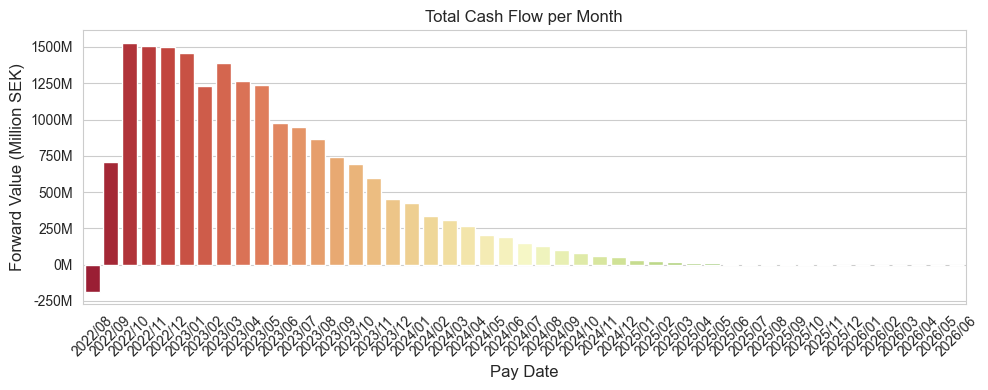

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

# Group by month and sum the values
grouped_risks = nok_cf_fv_SEK.groupby(pd.Grouper(key='Pay', freq='M')).sum()
grouped_risks.index.name = "Pay Date"

total_cash_flows = grouped_risks['Forward Value (SEK)'].reset_index()
total_cash_flows['Pay Date'] = pd.to_datetime(total_cash_flows['Pay Date'])
total_cash_flows['YearMonth'] = total_cash_flows['Pay Date'].dt.strftime('%Y/%m')

# Seaborn settings
sns.set_style("whitegrid")
sns.set_palette("RdYlGn", n_colors=len(total_cash_flows['Pay Date'].unique()))

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="YearMonth", y="Forward Value (SEK)", dodge=False, data=total_cash_flows, ax=ax)#,  color="#0874aa")

# Format the y-axis ticks to show values in millions
def millions_formatter(x, pos):
    return f'{x * 1e-6:.0f}M'
ax.yaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))

# Styling
ax.set_title("Total Cash Flow per Month", fontsize=12)
ax.set_xlabel("Pay Date", fontsize=12)
ax.set_ylabel("Forward Value (Million SEK)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

Cash flows per day can be graphed for a specific month.

NameError: name 'SimpleDocTemplate' is not defined

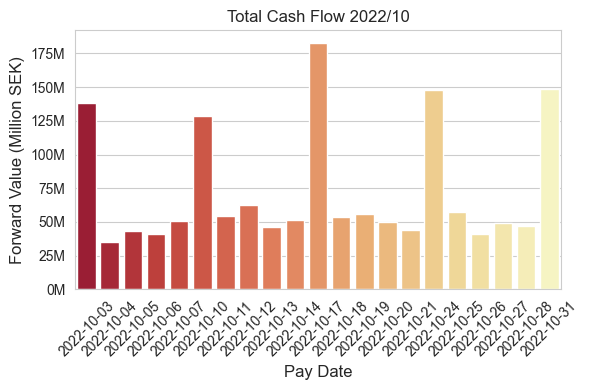

In [15]:
# Filter the dataframe for the month '2022-09'
filtered_df = nok_cf_fv_SEK[nok_cf_fv_SEK['Pay'].dt.to_period("M") == '2022-10']

# Group by each day and sum the values
daily_cash_flows = filtered_df.groupby(nok_cf_fv_SEK['Pay'].dt.to_period("D"))['Forward Value (SEK)'].sum().reset_index()

# Create the bar plot
fig, ax = plt.subplots(figsize=(6, 4))

# Set color palette
sns.set_palette("RdYlGn", n_colors=2*len(daily_cash_flows["Pay"].unique()))
sns.barplot(x="Pay", y="Forward Value (SEK)", data=daily_cash_flows, ax=ax)

# Styling
ax.yaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))
ax.set_title("Total Cash Flow 2022/10", fontsize=12)
ax.set_xlabel("Pay Date", fontsize=12)
ax.set_ylabel("Forward Value (Million SEK)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
pdf_filename = "table.pdf"
pdf_doc = SimpleDocTemplate(pdf_filename, pagesize=letter)
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle
from IPython.display import IFrame
plt.show()